In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

import torchvision

import monai.transforms as transforms
import medmnist

import numpy as np
import matplotlib.pyplot as plt

from typing import *
from PIL import Image

import random


In [2]:
organ_3d_data = medmnist.OrganMNIST3D(root="D:/", 
                                      split="train", 
                                      download=True)

Using downloaded and verified file: D:/organmnist3d.npz


In [3]:
organ_3d_data.info

{'python_class': 'OrganMNIST3D',
 'description': 'The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.',
 'url': 'https://zenodo.org/records/10519652/files/organmnist3d.npz?download=1',
 'MD5': 'a0c5a1ff56af4f155c46d46fbb45a2fe',
 'url_64': 'https://zenodo.org/records/10519652/files/organmnist3d_64.npz?download=1',
 'MD5_64': '58a2205adf14a9d0a189cb06dc78bf10',
 'task': 'multi-class',
 'label': {'0': 'liver',
  '1': 'kidney-right',
  '2': 'kidney-left',
  '3': 'femur-right',
  '4': 'femur-left',
  '5': 'bladder',
  '6': 'heart',
  '7': 'lung-right',
  '8': 'lung-left',
  '9

In [4]:
train_dataloader = torch.utils.data.DataLoader(organ_3d_data, batch_size=32, shuffle=True)
train_feature, train_label = next(iter(train_dataloader))

train_feature.size()

torch.Size([32, 1, 28, 28, 28])

In [175]:
title = train_label
train_feature.size()

train_feature[0].size()

torch.Size([1, 28, 28, 28])

In [ ]:
class RandomColorJitter:
    def __init__(self, p) -> None:
        self.p = p
    
    def __call__(self, img) -> torch.Tensor:
        if random.random() < self.p:
            torch.apply_(img, )

class RandomScaledCrop:
    def __init__(self, scale:Tuple[float, float]) -> None:
        """_summary_

        Args:
            scale (Tuple[float, float]): _description_
        """
        self.scale = scale
        
    def __call__(self, img):
        depth, width, height = img.size()[-3:]
        volume_dim = torch.Tensor([depth, width, height])

        rand_scale_factor = torch.empty(1).uniform_(*self.scale).item()
        
        dim_ratio = torch.Tensor([rand_scale_factor ** (1/3)]).repeat(3)
        target_volume_dim = torch.round(volume_dim * dim_ratio).to(torch.int32)
        
        indices = torch.round(torch.empty(3).uniform_(0, (volume_dim - target_volume_dim)[0])).to(torch.int32)
        
        cropped_img = img[: , indices[0]: indices[0] + target_volume_dim[0],
            indices[1]: indices[1] + target_volume_dim[1],
            indices[2]: indices[2] + target_volume_dim[2]]

        return cropped_img
        
class RandomResizedCrop:
    def __init__(self, size, scale:Tuple[float, float]) -> None:
        """
        Random Resized Crop 

        Args:
            size (_type_): _description_
            scale (Tuple[float, float]): _description_
            mode (_type_): _description_
        """
        self.size = size
        
        self.transform = transforms.Compose([
            RandomScaledCrop(scale=scale),
            transforms.Resize(spatial_size=size, mode="bicubic")
        ])
    
    def __call__(self, img) -> Any:
        return self.transform(img)

        

In [ ]:
resized_transformation = RandomResizedCrop(size=(32, 32, 32), 
                                           scale=(0.05, 0.4))
train_feature[0].size()
resized_transformation(train_feature[0]).size()

RuntimeError: applying transform <monai.transforms.spatial.array.Resize object at 0x000001FFE6F612B0>

In [ ]:
flip_and_color_jitter = transforms.Compose([
    transforms.LoadImage(),
    transforms.RandFlip(prob=0.5, spatial_axis=0)
])

normalize = transforms.Compose([
    transforms.NormalizeIntensity()
])

global_transfo1 = transforms.Compose([
    transforms.Resize()
])

In [ ]:
g_transform = transforms.CutOut(batch_size=32)
transformed_img = g_transform(train_feature)

train_feature.size()

In [ ]:
import math

# Code from torchvision.transforms.RandomResizedCrop()

data = torch.rand(1, 1, 32, 32, 32)
scale = (0.05, 0.4)
ratio = (3/4, 4/3)

_, _, depth, width, height =  data.size()
volume = height * width * depth
log_ratio = torch.log(torch.Tensor(ratio))

target_volume = volume * torch.empty(1).uniform_(scale[0], scale[1]).item()
aspect_ratio = torch.exp(torch.empty(1).uniform_(log_ratio[0], log_ratio[1])).item()

w = int(round(math.sqrt(target_volume * aspect_ratio)))
h = int(round(math.sqrt(target_volume / aspect_ratio)))

if 0 < w <= width and 0 < h <= height:
    
    # What do the i and j mean
    # height = 32, h = 21
    
    # Determines the starting point for the crop
    i = torch.randint(0, height - h + 1, size=(1,)).item()
    j = torch.randint(0, width - w + 1, size=(1,)).item()
    print(i, j, h, w)

383.86187744140625
1 5 21 18


In [184]:
def random_resized():
    
    # torch.manual_seed(42)

    depth, width, height = img.size()[-3:]
    volume_dim = torch.Tensor([depth, width, height])

    rand_scale_factor = torch.empty(1).uniform_(*scale).item()
    volume = torch.prod(volume_dim)
    
    target_volume = volume * rand_scale_factor
    
    dim_ratio = torch.Tensor([rand_scale_factor ** (1/3)]).repeat(3)
    target_volume_dim = torch.round(volume_dim * dim_ratio).to(torch.int32)
    
    indices = torch.round(torch.empty(3).uniform_(0, (volume_dim - target_volume_dim)[0])).to(torch.int32)
    
    cropped_img = img[: , indices[0]: indices[0] + target_volume_dim[0],
        indices[1]: indices[1] + target_volume_dim[1],
        indices[2]: indices[2] + target_volume_dim[2]]
    
    return cropped_img

cropped_img = random_resized()
print(cropped_img.size())
resize_transform = transforms.Resize(spatial_size=(32,32,32))

resize_transform(cropped_img).size()
# cropped_img.size()

torch.Size([1, 0, 23, 23, 32])


ValueError: len(spatial_size) must be greater or equal to img spatial dimensions, got spatial_size=3 img=4.

In [5]:
from PIL import ImageFilter, ImageOps
from PIL import Image
import random



class GaussianBlur(object):
    """
    Apply Gaussian Blur to the PIL image.
    """
    def __init__(self, p=0.5, radius_min=0.1, radius_max=2.):
        self.prob = p
        self.radius_min = radius_min
        self.radius_max = radius_max

    def __call__(self, img):
        do_it = random.random() <= self.prob
        if not do_it:
            return img

        return img.filter(
            ImageFilter.GaussianBlur(
                radius=random.uniform(self.radius_min, self.radius_max)
            )
        )

class Solarization(object):
    """
    Apply Solarization to the PIL image.
    """
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return ImageOps.solarize(img)
        else:
            return img


In [ ]:
s = Solarization(1)


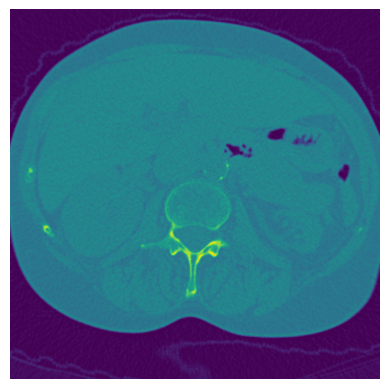

In [22]:
import glob
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk

import nibabel as nib

LUNA_DATA_DIR = "D:/LUNA16 S1/subset1/"

mhd_files = glob.glob(f"{LUNA_DATA_DIR}/*.mhd", recursive=True)
image = sitk.ReadImage(mhd_files[0])

image_array = sitk.GetArrayFromImage(image)
example_img = image_array[0]

plt.axis("off")
plt.imshow(example_img)
plt.show()

# Image.fromarray(example_img)
# gaussian_example_img = g()
# plt.imshow(gaussian_example_img, cmap="gray")


torch.Size([240, 240, 155, 4])


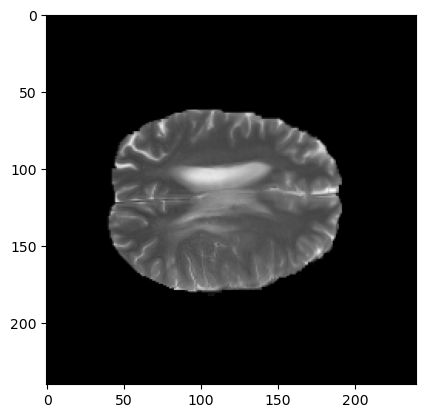

In [69]:
BRATS_DATAPATH = "D:/Task01_BrainTumour/imagesTr/"
brats_img_path = glob.glob(f"{BRATS_DATAPATH}/*.nii.gz", recursive=True)

brats_img1 = torch.Tensor(nib.load(brats_img_path[0]).get_fdata())
print(brats_img1.size())
test_img = brats_img1.permute(3, 2, 0, 1)[3][100]

plt.imshow(test_img, cmap="gray")


In [95]:
brats_img1.size()

torch.Size([240, 240, 155, 4])

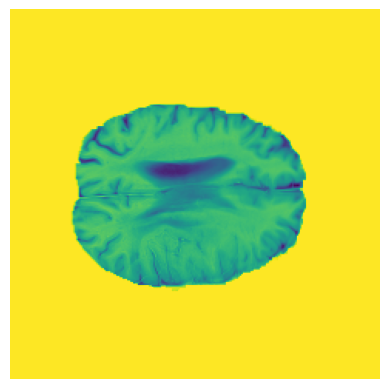

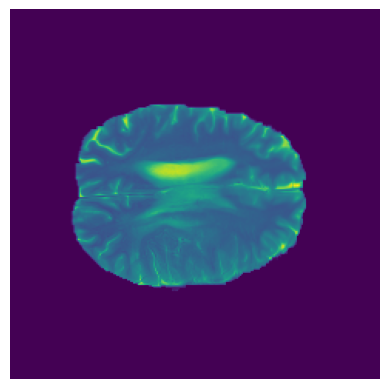

In [ ]:
# print(test_img.view(1, 240, 240))

class Solarize:
    def __init__(self, prob:float=0.5, threshold:float=0.5) -> None:
        self.transform = torchvision.transforms.RandomSolarize(threshold, prob)
    
    def __call__(self, img):
        return self.transform(img)

class GaussianBlur:
    def __init__(self, prob:float=0.5, kernel_size=5) -> None:
        self.prob = prob
        self.transform = torchvision.transforms.GaussianBlur(kernel_size)
        
    def __call__(self, img):
        if random.random() > self.prob:
            return self.transform(img)
        
        return img

color_jitter = torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)
gaussian_blur = torchvision.transforms.GaussianBlur(1)
solarization = torchvision.transforms.RandomSolarize(0.1, 1)

solarized_img = solarization(test_img.view(1, 240, 240))
gaussian_blur_img = gaussian_blur(test_img.view(1, 240, 240))

plt.axis("off")
plt.imshow(solarized_img.squeeze())
plt.show()

plt.axis("off")
plt.imshow(gaussian_blur_img.squeeze())
plt.show()

